In [386]:
import os
from scipy.io import loadmat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

channel_labels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
                  'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

In [410]:
raw_data = pd.read_csv("eeg_data.csv")
print(raw_data.shape)
raw_data.head()

(965943, 21)


,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T7,T8,P7,P8,Fz,Cz,Pz,Group,PersonID
0,85.0,-19.0,163.0,85.0,347.0,16.0,457.0,310.0,568.0,310.0,...,16.0,384.0,200.0,457.0,163.0,85.0,121.0,332.0,1,0
1,121.0,-55.0,273.0,156.0,384.0,52.0,641.0,420.0,678.0,494.0,...,52.0,273.0,273.0,420.0,200.0,121.0,156.0,367.0,1,0
2,191.0,85.0,347.0,297.0,384.0,236.0,678.0,568.0,715.0,568.0,...,89.0,273.0,310.0,494.0,200.0,191.0,297.0,473.0,1,0
3,261.0,85.0,347.0,261.0,420.0,384.0,862.0,531.0,899.0,494.0,...,16.0,310.0,310.0,568.0,89.0,261.0,261.0,578.0,1,0
4,191.0,156.0,310.0,367.0,310.0,568.0,788.0,531.0,678.0,494.0,...,126.0,273.0,457.0,420.0,163.0,261.0,297.0,437.0,1,0


In [489]:
preprocessed_df = pd.read_csv("preprocessed_eeg_data.csv")
print(preprocessed_df.shape)
preprocessed_df.head()

(2013165, 22)


,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,T7,T8,P7,P8,Fz,Cz,Pz,PersonID,Group,Epoch
0,289.138952,255.799249,-91.806889,-40.774209,-183.954108,52.441948,-39.977857,-152.931870,-170.212102,-185.223937,...,-82.023457,-39.979308,-39.278720,-130.748064,254.340898,7.877779,-29.020594,0,1,0
1,254.400732,268.025103,-25.378559,-37.884554,-169.397148,56.870408,-98.365063,-155.728222,-209.581650,-181.877073,...,-133.791645,-75.663108,-49.612804,-132.457557,252.564338,5.332767,-21.098542,0,1,0
2,192.754132,316.533648,-45.144802,-53.918429,-156.935842,80.382479,-140.744375,-133.278910,-205.710102,-177.689013,...,-82.221963,-9.438054,-96.173650,-105.136624,196.075551,-11.243148,-30.419882,0,1,0
3,174.566402,322.720300,-111.757016,-19.328036,-151.489698,68.721473,-122.486124,-143.895740,-160.639622,-217.197539,...,-27.629680,58.166813,-137.396853,-84.957646,146.688988,-65.589759,-39.449590,0,1,0
4,160.411782,307.402489,-146.795877,-28.526291,-119.346442,-63.152719,-76.713983,-207.696847,-111.804413,-267.342161,...,-6.015160,27.232427,-14.350615,-82.753854,140.903721,-109.581276,-21.937077,0,1,0


In [490]:
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import hilbert, welch, coherence
from nolds import dfa
from IPython.display import clear_output

# Frequency bands
bands = {
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30)
}

def extract_features(data, fs=128, channel_labels=None):
    features = []  # feature dictionaries for each epoch and person

    # Group data by Epoch and PersonID
    grouped = data.groupby(['Epoch', 'PersonID'])

    epoch_count = 0
    for (epoch, person_id), group in grouped:
        clear_output(wait=True)
        
        epoch_features = {
            'Epoch': epoch,
            'PersonID': person_id,
            'Group': group['Group'].iloc[0]
        }

        # features for each channel
        for channel_name in channel_labels:
            channel_signal = group[channel_name].values  
            
            # Compute Power Spectral Density (PSD)
            freqs, psd = welch(channel_signal, fs=fs, nperseg=256)
            theta_power = beta_power = None  # Initialize power bands
                
            for band_name, (fmin, fmax) in bands.items():
                band_power = psd[(freqs >= fmin) & (freqs <= fmax)].mean()
                epoch_features[f'{channel_name}_{band_name}_Power'] = band_power  # power bands for each channel
                
                # Save specific band powers for TBR
                if band_name == 'Theta':
                    theta_power = band_power
                elif band_name == 'Beta':
                    beta_power = band_power

            # Compute TBR for each channel
            epoch_features[f'{channel_name}_TBR'] = (theta_power / beta_power) if (theta_power and beta_power and beta_power > 0) else None
        
            # Compute amplitude envelope features for each channel
            amplitude_envelope = np.abs(hilbert(channel_signal))
            epoch_features[f'{channel_name}_Envelope_Mean'] = amplitude_envelope.mean()
            epoch_features[f'{channel_name}_Envelope_Std'] = amplitude_envelope.std()
                
            # Compute variance for each channel
            epoch_features[f'{channel_name}_Variance'] = np.var(channel_signal)
            # get fractional dimension for each channel
            epoch_features[f'{channel_name}_FractalDimension'] = dfa(channel_signal)
            # Signal entropy
            epoch_features[f'{channel_name}_Entropy'] = entropy(np.abs(channel_signal))   


        # calculate mean TBR for frontal lobe channels
        frontal_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz']
        epoch_features['Frontal_TBR_mean'] = np.mean(
            [epoch_features[f'{ch}_TBR'] for ch in frontal_channels if f'{ch}_TBR' in epoch_features]
        )
                
        features.append(epoch_features)
        print(f"Processed epoch {epoch_count+1}/{grouped.ngroups}")
        epoch_count = epoch_count+1

    # return features as dataframe
    return pd.DataFrame(features)

features_df = extract_features(preprocessed_df, fs=128, channel_labels=channel_labels)
print(features_df.shape)

Processed epoch 5229/5229
(5229, 175)


In [501]:
features_df.to_csv("epoch_features.csv", index=False)

In [467]:
features_df = pd.read_csv("epoch_features.csv", index_col=0)

In [491]:
epoch_data = features_df.copy()

# Group by PersonID and aggregate epochs 
time_series_df = epoch_data.groupby('PersonID').agg(
    {col: ['mean', 'var', 'std', 'min', 'max', 'median'] 
     for col in epoch_data.columns if col not in ['PersonID', 'Epoch', 'Group']}
).reset_index()

time_series_df.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in time_series_df.columns]

# add back group column
group_column = epoch_data.groupby('PersonID')['Group'].first().reset_index()

# merge the aggregated features with the group and epoch column
time_series_df = pd.merge(time_series_df, group_column, on='PersonID')

time_series_df.head(10)

,PersonID,Fp1_Theta_Power_mean,Fp1_Theta_Power_var,Fp1_Theta_Power_std,Fp1_Theta_Power_min,Fp1_Theta_Power_max,Fp1_Theta_Power_median,Fp1_Alpha_Power_mean,Fp1_Alpha_Power_var,Fp1_Alpha_Power_std,...,Pz_Entropy_min,Pz_Entropy_max,Pz_Entropy_median,Frontal_TBR_mean_mean,Frontal_TBR_mean_var,Frontal_TBR_mean_std,Frontal_TBR_mean_min,Frontal_TBR_mean_max,Frontal_TBR_mean_median,Group
0,0,687.442477,117071.452042,342.157058,278.441049,2022.385534,596.884109,500.758041,38422.545539,196.016697,...,5.602919,5.715205,5.673440,5.925577,2.972686,1.724148,2.962132,9.963064,5.868104,1
1,1,409.180051,26160.157484,161.741020,146.280520,947.494678,378.896175,165.851682,3132.376820,55.967641,...,5.605237,5.731726,5.665966,6.347571,4.015536,2.003880,3.744077,11.526932,5.715621,1
2,2,276.347600,48886.347321,221.102572,87.503347,1047.146676,207.099557,175.655715,9109.489229,95.443644,...,5.589978,5.716448,5.662851,5.298457,8.279222,2.877364,1.925327,13.355523,4.672076,1
3,3,650.295001,72203.777685,268.707606,255.445800,1272.304380,553.860766,279.784919,19074.306941,138.109764,...,5.575673,5.724676,5.661487,6.829581,4.791393,2.188925,2.812403,10.964228,6.523190,1
4,4,153.900362,4742.292049,68.864302,67.304106,361.998116,129.865410,117.323783,1411.866757,37.574815,...,5.607442,5.709969,5.663654,5.888306,3.295383,1.815319,3.069146,10.278675,5.359427,1
5,5,151.056211,2522.876311,50.228242,62.228428,296.948129,144.838080,120.021248,2420.360381,49.197158,...,5.594729,5.719787,5.665384,6.588609,4.120378,2.029871,4.007275,13.342925,6.152817,1
6,6,415.816193,63962.575187,252.908235,150.909774,1060.580883,333.128443,284.290117,8411.790601,91.715814,...,5.608863,5.698351,5.663314,6.122328,3.543284,1.882361,3.600793,11.814812,5.883845,1
7,7,229.589487,6898.772625,83.058850,84.578164,451.161491,215.672884,125.518805,1866.725840,43.205623,...,5.587689,5.725957,5.671168,7.269124,7.933914,2.816720,3.206652,17.050308,6.594022,1
8,8,488.770420,43795.135300,209.272873,166.004345,1037.605100,438.323204,199.941165,4525.642387,67.272895,...,5.480169,5.718863,5.658055,8.129890,11.839911,3.440917,3.827838,22.774773,7.520131,1
9,9,218.661857,6390.130071,79.938289,87.339163,461.843014,215.232091,157.128470,3989.211232,63.160203,...,5.584825,5.717265,5.654949,6.460683,3.572202,1.890027,3.604294,13.088182,6.216498,1


In [492]:
# split into testing and training set
from sklearn.model_selection import train_test_split

X = time_series_df.drop(columns=['Group', 'PersonID'])  
y = time_series_df['Group']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [493]:
from sklearn.feature_selection import f_classif

def get_significant_features(features, labels):
    # Perform ANOVA
    f_values, p_values = f_classif(features, labels)
    
    anova_results = pd.DataFrame({
        'Feature': features.columns,  # Feature names
        'F-Statistic': f_values,      # F-statistic values
        'P-Value': p_values           # p-values
    })

    # filter out non significant features
    significant_features = anova_results[anova_results['P-Value'] < 0.05]
    return significant_features

In [494]:
significant_features = get_significant_features(X_train, y_train)
significant_features.to_csv('feature_list_train.csv')
significant_features.shape

(121, 3)

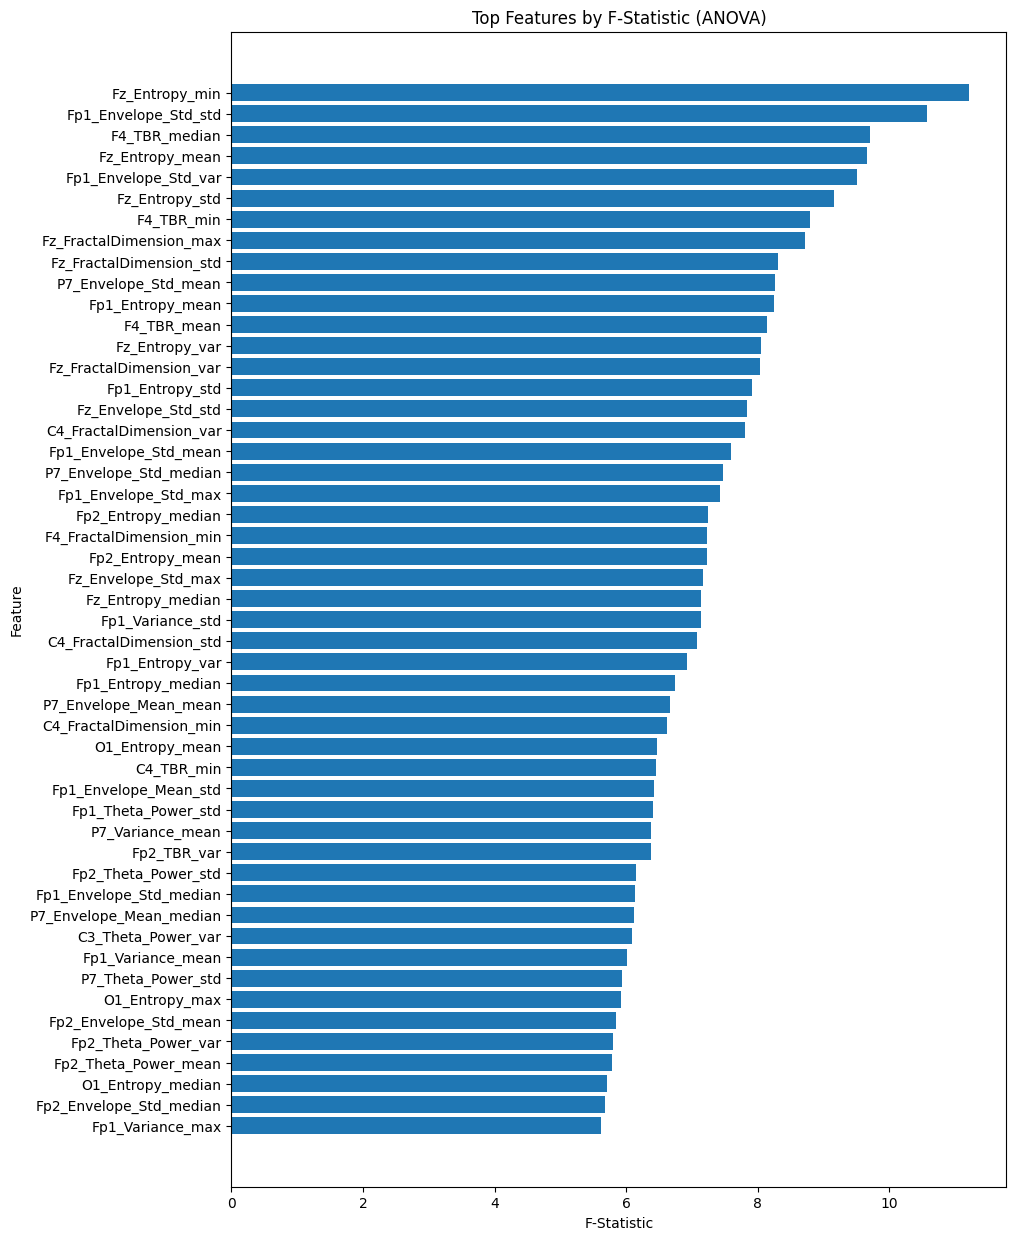

In [495]:
# Sort features by F-Statistic
top_features = significant_features.sort_values('F-Statistic', ascending=False).head(50)

# Plot top features
plt.figure(figsize=(10, 15))
plt.barh(top_features['Feature'], top_features['F-Statistic'])
plt.xlabel('F-Statistic')
plt.ylabel('Feature')
plt.title('Top Features by F-Statistic (ANOVA)')
plt.gca().invert_yaxis()  
plt.show()

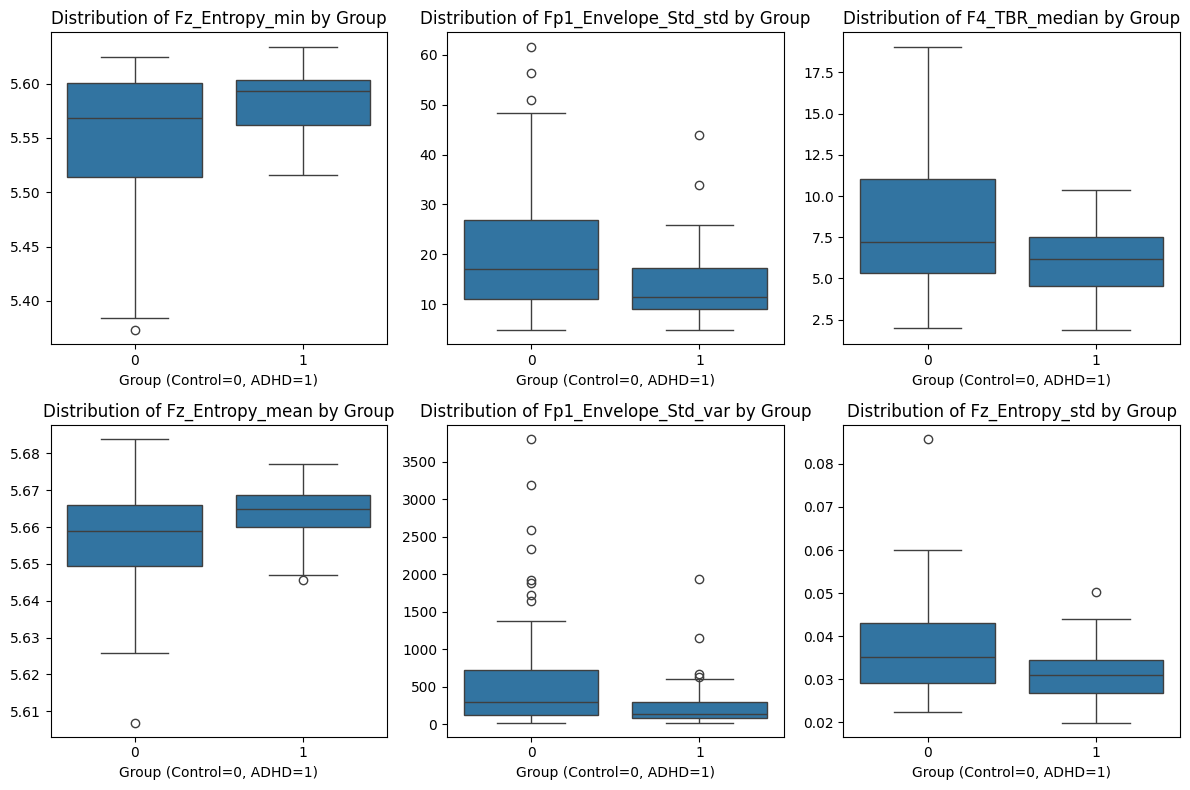

In [496]:
# plot boxplots for top 6 features
plot_features = significant_features.sort_values('F-Statistic', ascending=False)['Feature'].head(6)

plt.figure(figsize=(12, 8))
for i, feature in enumerate(plot_features, 1):  
    plt.subplot(2, 3, i)  
    sns.boxplot(x= y_train, y= X_train[feature])
    plt.title(f'Distribution of {feature} by Group')
    plt.xlabel('Group (Control=0, ADHD=1)')
    plt.ylabel(None)

plt.tight_layout()
plt.show()

In [497]:
# remove insignificant features from data
significant_feature_names = significant_features['Feature'].tolist()

X_train = X_train[significant_feature_names]
X_test = X_test[significant_feature_names]

sig_features_df = time_series_df[['PersonID', 'Group'] + significant_feature_names]
sig_features_df.to_csv('sig_features.csv', index=False)

In [498]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = X_train
y = y_train 

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso model
lasso = Lasso(alpha=0.01)  
lasso.fit(X_scaled, y)

# Get feature importance
feature_names = X.columns
lasso_coefficients = lasso.coef_

# Select non-zero coefficients 
important_features = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients
}).query("Coefficient != 0").sort_values(by="Coefficient", ascending=False)


print("Selected Features:")
print(important_features)

Selected Features:
                        Feature  Coefficient
61      C4_FractalDimension_var     0.212155
98            P7_Entropy_median     0.125975
50   F4_FractalDimension_median     0.108062
100         Fz_Envelope_Std_var     0.068962
73               O1_Entropy_max     0.068337
97           P7_Variance_median     0.057674
112              Fz_Entropy_max     0.055355
35         Fp2_Envelope_Std_std     0.051026
113           Fz_Entropy_median     0.049732
111              Fz_Entropy_min     0.048013
3           Fp1_Theta_Power_max     0.043190
71         O1_Envelope_Std_mean     0.040329
60                C4_TBR_median     0.038231
83           P7_Theta_Power_max     0.034728
25           Fp1_Entropy_median     0.025806
72              O1_Entropy_mean     0.022671
0          Fp1_Theta_Power_mean     0.011595
77          F7_Theta_Power_mean     0.007238
104             Fz_Variance_max     0.002818
45                  F4_TBR_mean     0.001495
76       O2_Envelope_Std_median    -

In [499]:
lasso_feature_names = important_features['Feature'].tolist()

lasso_features_df = time_series_df[['PersonID', 'Group'] + lasso_feature_names]
lasso_features_df.to_csv('lasso_features.csv', index=False)

In [500]:
# save split for models
X_train = X_train[lasso_feature_names]
X_test = X_test[lasso_feature_names]

X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)